# Calculate Spatial and temporal NME scores, then calculate ensemble weights.

In [2]:
import os
import math
from copy import deepcopy

import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import tqdm
tqdm.tqdm.pandas(desc='Progress bar')
from kneed import KneeLocator

from Functions import *
from Global_Variables import *

In [3]:
obs_df = add_global(pd.read_pickle(os.path.join(RESULTS_PATH, 'AR6_obs_df.pkl')))
obsclim_df = add_global(pd.read_pickle(os.path.join(RESULTS_PATH, 'AR6_obsclim_df.pkl')))
counterclim_df = add_global(pd.read_pickle(os.path.join(RESULTS_PATH, 'AR6_counterclim_df.pkl')))

start_year, end_year = 2003, 2019
rng = np.random.default_rng(SEED)

## Calculate Error scores

### Spatial NME

In [67]:
warnings.filterwarnings('ignore') # Surpress some unimportant warnings

NME_scores = pd.DataFrame(index=pd.MultiIndex.from_product([obs_dict.keys(), ('$NME_1$', '$NME_3$')], names=['Observation', 'NME']), columns=obsclim_df.columns.unique(level='Model'))

for obsname in NME_scores.index.unique(level='Observation'):
    obs = constrain_time(iris.load_cube(obs_dict[obsname]), start_year, end_year)
    for modelname in NME_scores.columns.unique(level='Model'):
        model = constrain_time(preprocess_model(iris.load_cube(model_dict[modelname]['obsclim']), modelname), start_year, end_year)
        NME_scores.loc[(obsname), modelname] = [NME1(obs, model), NME3(obs, model)]

warnings.filterwarnings('default')   
NME_scores.to_pickle(os.path.join(RESULTS_PATH, 'NME_scores_spatial.pkl'))       

### RMSE

In [3]:
obs_pd = constrain_time(obs_df, start_year, end_year)
obs_double_df = obs_pd.stack(sort=False).swaplevel(0, 1).sort_index()
obs_yearly_double_df = to_annual(obs_pd).stack(sort=False).swaplevel(0, 1).sort_index()

obsclim_pd = constrain_time(obsclim_df, start_year, end_year)
obsclim_double_df = pd.concat([obsclim_pd]*2)
obsclim_yearly_double_df = pd.concat([to_annual(obsclim_pd)]*2)

RMSE_RA_monthly_df = pd.DataFrame(index=['RMSE'], columns=obsclim_df.columns)
RMSE_RA_annual_df = pd.DataFrame(index=['RMSE'], columns=obsclim_df.columns)
RMSE_monthly_RA_monthly_df = pd.DataFrame(index=obs_pd.index.month.unique(), columns=obsclim_df.columns)
RMSE_monthly_RA_monthly_df.index.name = 'Month'
RMSE_monthly_log_RA_monthly_df = pd.DataFrame(index=obs_pd.index.month.unique(), columns=obsclim_df.columns)
RMSE_monthly_log_RA_monthly_df.index.name = 'Month'

for regionname, modelname in RMSE_RA_monthly_df.columns:
    obs_RA = obs_double_df.loc[slice(None), regionname].groupby('Observation', observed=True).apply(lambda df: relative_anomaly(df)).droplevel(1).droplevel('Observation')
    model_RA = obsclim_double_df.loc[slice(None), regionname].stack('Model').groupby('Model', observed=True).apply(lambda df: relative_anomaly(df)).droplevel(2)
    RMSE_RA_monthly_df.loc['RMSE', (regionname)] = model_RA.groupby('Model', observed=False).apply(lambda model: ((obs_RA - model.droplevel('Model'))**2).mean()**.5).values
    
    obs_yearly_RA = obs_yearly_double_df.loc[slice(None), regionname].groupby('Observation', observed=True).apply(lambda df: relative_anomaly(df)).droplevel(1).droplevel('Observation')
    model_yearly_RA = obsclim_yearly_double_df.loc[slice(None), regionname].stack('Model').groupby('Model', observed=True).apply(lambda df: relative_anomaly(df)).droplevel(2)
    RMSE_RA_annual_df.loc['RMSE', (regionname)] = model_yearly_RA.groupby('Model', observed=False).apply(lambda model: ((obs_yearly_RA - model.droplevel('Model'))**2).mean()**.5).values
    
    
    for month_idx in RMSE_monthly_RA_monthly_df.index:
        obs_RA_month = obs_RA.loc[obs_RA.index.month == month_idx]
        model_RA_month = model_RA.loc[model_RA.index.get_level_values(1).month == month_idx]
        RMSE_monthly_RA_monthly_df.loc[month_idx, (regionname)] = model_RA_month.groupby('Model', observed=False).apply(lambda model: ((obs_RA_month - model.droplevel('Model'))**2).mean()**.5).values
        RMSE_monthly_log_RA_monthly_df.loc[month_idx, (regionname)] = model_RA_month.groupby('Model', observed=False).apply(lambda model: ((log_transform(obs_RA_month) - log_transform(model).droplevel('Model'))**2).mean()**.5).values

        
RMSE_RA_monthly_df.to_pickle(os.path.join(RESULTS_PATH, 'RMSE_RA_monthly.pkl'))
RMSE_RA_annual_df.to_pickle(os.path.join(RESULTS_PATH, 'RMSE_RA_annual.pkl'))
RMSE_monthly_RA_monthly_df.to_pickle(os.path.join(RESULTS_PATH, 'RMSE_monthly_RA_monthly.pkl'))
RMSE_monthly_log_RA_monthly_df.to_pickle(os.path.join(RESULTS_PATH, 'RMSE_monthly_log_RA_monthly.pkl'))

## Optimal sigmaD (1000 times)

### Temporal NME

Calculate __for__ each region, __for__ each of the the two observations the temporal NME3 scores (annual and ranked) of the _fire models_ and the _reference model_ (randomly resampled observations).

In [4]:
rng = np.random.default_rng(SEED)
start_year, end_year = 2003, 2019
index = pd.MultiIndex.from_product([obs_dict.keys(), ('NME3_ranked', 'NME3_annual')], names=['Observation', 'NME'])
NME_scores = pd.DataFrame(index=index, columns=obsclim_df.columns, dtype=np.float32)

columns = obsclim_df.columns.unique(level='Region')
NME_ref_scores = pd.DataFrame(index=index, columns=columns, dtype=np.float32)

for regionname, modelname in NME_scores.columns:
    obs = constrain_time(select_region(obs_df, regionname), start_year, end_year)
    model = constrain_time(select_region(select_models(obsclim_df, modelname), regionname), start_year, end_year)
       
    for obs_name in NME_scores.index.unique(level='Observation'):
        obs_select = select_models(obs, obs_name)
        obs_series, model_series = obs_select[(regionname, obs_name)], model[(regionname, modelname)]
        obs_annual_series, model_annual_series = to_annual(obs_select)[(regionname, obs_name)], to_annual(model)[(regionname, modelname)]
        
        random_obs = pd.Series(rng.choice(obs_select.values.flatten(), size=len(obs.index), replace=False), index=obs_select.index)
        
        NME_scores.loc[(obs_name), (regionname, modelname)] = (NME3_temporal(obs_series.sort_values(), model_series.sort_values()), NME3_temporal(obs_annual_series, model_annual_series))
        NME_ref_scores.loc[(obs_name), (regionname)] = [NME3_temporal(obs_series.sort_values(), random_obs), NME3_temporal(to_annual(obs_series), to_annual(random_obs))]

NME_scores.to_pickle(os.path.join(RESULTS_PATH, 'NME_scores_temporal.pkl'))
NME_ref_scores.to_pickle(os.path.join(RESULTS_PATH, 'NME_ref_scores_temporal.pkl'))

In [5]:
max_sigmaD = 10
sigmaDs = pd.Series(np.logspace(0.01, np.log2(max_sigmaD+1), base=2,num=500, dtype=np.float32)-1, name='sigmaD')
model_weights = pd.DataFrame(np.nan, index=sigmaDs, columns=obsclim_df.columns, dtype=np.float64)

distances = pd.to_numeric((NME_scores/NME_scores.T.groupby(level='Region', sort=False, observed=True).median().T).sum())
for sigmaD in model_weights.index:
    weights_not_normalized = (-distances/sigmaD).apply(lambda x: np.exp(x))
    weights_normalized = weights_not_normalized/weights_not_normalized.groupby(level=('Region'), sort=False, observed=True).sum()
    model_weights.loc[(sigmaD), slice(None)] = weights_normalized

In [6]:
obsclim_pd = constrain_time(obsclim_df, start_year, end_year)
obsclim_pd_RA = relative_anomaly(pd.concat([obsclim_pd]*2))
obs_pd_RA_df = relative_anomaly(constrain_time(obs_df, start_year, end_year)).stack(sort=False).swaplevel(0, 1).sort_index().droplevel('Observation')

num_loops = 1000
fraction_correct = []

for idx in tqdm.tqdm(range(num_loops)):
    obsclim_pd_RA_added_noise = add_error(obsclim_pd_RA, seed=idx, error=RMSE_monthly_log_RA_monthly_df)
    fraction_correct_idx = []
    
    for sigmaD in sigmaDs:
        weights = model_weights.loc[sigmaD]
        weighted_average = (obsclim_pd_RA_added_noise*weights).T.groupby(level='Region', sort=False, observed=True).sum().T
        
        variance = obsclim_pd_RA_added_noise.subtract(weighted_average, axis=0)**2
        weighted_variance = variance*weights
        weighted_variance_regional = weighted_variance.T.groupby(level='Region', sort=False, observed=True).sum().T
        weighted_stddev = np.sqrt(weighted_variance_regional)
        
        upper_bound = weighted_average+1.96*weighted_stddev
        lower_bound = weighted_average-1.96*weighted_stddev
        
        fraction_correct_idx_sigmaD = ((obs_pd_RA_df <= upper_bound) & (obs_pd_RA_df >= lower_bound)).mean(axis=0)
        fraction_correct_idx_sigmaD.name = sigmaD
        fraction_correct_idx.append(fraction_correct_idx_sigmaD)
        
    fraction_correct_idx = pd.concat(fraction_correct_idx, axis=1).T
    fraction_correct_idx.index.name = 'sigmaD'
    fraction_correct.append(fraction_correct_idx)
    
fraction_correct = pd.concat(fraction_correct, keys=np.arange(num_loops), names=['idx', 'sigmaD'])
fraction_correct.to_pickle(os.path.join(RESULTS_PATH, 'fraction_correct.pkl'))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [49:28<00:00,  2.97s/it]


In [7]:
def get_best_knee(kneelocator):
    y_knees = list(kneelocator.all_knees_y)
    best_idx = 0
    for idx, y in enumerate(y_knees):
        if y >= y_knees[best_idx]+0.01:
            best_idx = idx   
            if y >= 0.95:
                break
    return pd.Series([list(kneelocator.all_knees)[best_idx], y_knees[best_idx]], index=['sigmaD', 'fraction_correct'])

In [8]:
knees = fraction_correct.stack('Region').unstack('sigmaD').groupby(['idx', 'Region'], observed=False).progress_apply(lambda row: KneeLocator(x=row.columns.values, y=row.values[0], S=15, direction='increasing', online=True))
knee_results = knees.progress_apply(lambda kl: get_best_knee(kl))
knee_results.to_pickle(os.path.join(RESULTS_PATH, 'knees.pkl'))

Progress bar: 100%|████████████████████████████████████████████████████████████| 44000/44000 [00:08<00:00, 5322.99it/s]


In [9]:
optimal_sigmaDs = knee_results.sigmaD.unstack('Region')

optimal_weights = pd.DataFrame(index=optimal_sigmaDs.index, columns=model_weights.columns, dtype=np.float32)
for regionname in optimal_sigmaDs.columns:
    region_weights = model_weights.loc[(optimal_sigmaDs.loc[slice(None), regionname].dropna()), (regionname)]
    optimal_weights.loc[(~optimal_sigmaDs.loc[slice(None), regionname].isna()), (regionname)] = region_weights.values.astype(np.float32)

optimal_weights.index = optimal_weights.index.astype(np.int16)
optimal_weights.to_pickle(os.path.join(RESULTS_PATH, 'optimal_weights.pkl'))

In [15]:
knee_results = pd.read_pickle(os.path.join(RESULTS_PATH, 'knees.pkl'))
fraction_correct = pd.read_pickle(os.path.join(RESULTS_PATH, 'fraction_correct.pkl'))

In [52]:
idx=1
fraction_global = fraction_correct.loc[idx, 'Global']
best = knee_results.loc[idx, 'Global']

In [24]:
best = knee_results.groupby('Region').mean().loc['Global']
fraction_global = fraction_correct.stack().groupby(['sigmaD', 'Region']).mean().loc[(slice(None), 'Global')]

C:\Users\slampe\AppData\Local\Temp\ipykernel_13720\4054558147.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  best = knee_results.groupby('Region').mean().loc['Global']


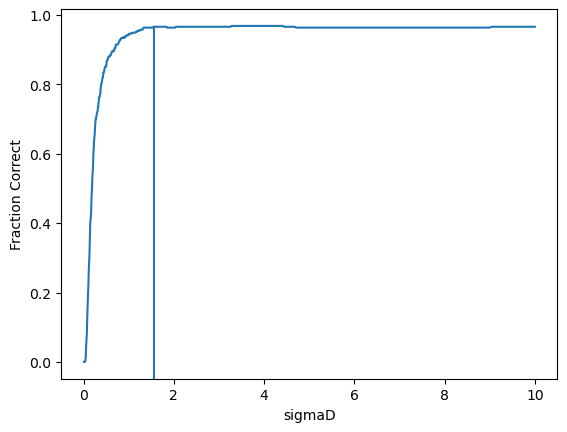

In [55]:
fraction_global.name = 'Fraction Correct'
global_plot = sns.lineplot(fraction_global)
global_plot.axvline(x=best.sigmaD, ymin=0, ymax=best.fraction_correct*0.98)
plt.savefig('test.png', dpi=300, bbox_inches='tight', transparent=True)

In [40]:
height = np.interp(best, global_plot.lines[0].get_xdata(), global_plot.lines[0].get_ydata())
global_plot.axvline(x=best.sigmaD, ymin=0, ymax=best.fraction_correct)

In [36]:
global_plot.lines

<Axes.ArtistList of 1 lines>

In [38]:
height

array([0.96655582, 0.94163101])

In [39]:
best

sigmaD              2.024660
fraction_correct    0.968176
Name: Global, dtype: float64